# Creation of Land Use Change Tables from Generated Google Earth Assets


In [ ]:
import ee
import geemap
import geemap.ml as ml
from ipygee import chart as chart
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import pymannkendall as mk
import xarray as xr
import os
# Import date class from datetime module
from datetime import datetime as dt
import datetime
import pytz

today = dt.today()
print("Today is: ", today)

# GEE Authentication 
 
 ### Paste the Authetication code into the box below if prompted to save token
 
 
 (press enter to save token)


In [ ]:
# ee.Authenticate()

In [ ]:
geemap.ee_initialize()

### New version control of inputs and outputs

* best to check that catchment hydroclimatic information is indeed the most reliable/latest available

In [4]:
p = '..'

version = 'Version_3_20230303'

l_BE = pd.read_excel(f"{p}\Inputs\Version_3_20230303\BE.xlsx").catchment.tolist()
l_FR = pd.read_excel(f"{p}\Inputs\Version_3_20230303\FR.xlsx").catchment.tolist()

ls = l_BE+l_FR

def drop_space(i) -> str:
    '''
    Since the FR and BE data is given with indices using catchment names,
    it is necessary to check and drop the space at the end of each name where applicable.
    
    list the letters, check the last charachter for a space and delete if necessary. 
    '''
    
    ls = list(i)
    
    if ls[-1] == ' ':
        i = i[:-1]
    else:
        i = i
    return i

ls = ['Membre Pont', 'Straimont', 'Treignes', 'Chooz', 'Daverdisse', 'Jemelle', 'Hastiere', 'Warnant', 'Ortho',
      'Wiheries', 'Salzinnes', 'Huccorgne', 'Amay', 'La Meuse Goncourt', 'Le Mouzon Circourt-sur-Mouzon [Villars]',
      'Le Vair Soulosse-sous-Saint-Élophe', 'La Meuse Saint-Mihiel', 'La Meuse Stenay', 'La Chiers Longlaville',
      'La Chiers Carignan', 'La Bar Cheveuges', 'La Vence la Francheville',
      'La Sormonne Belval', 'Le Loison Han-lés-Juvigny', 'La Crusnes Pierrepont', 'Le Ton Écouviez', 'Sainte-Marie']

names = [drop_space(i) for i in ls]

print(f'{len(names)} catchments passed for classification:\n \n{names}')

27 catchments passed for classification:
 
['Membre Pont', 'Straimont', 'Treignes', 'Chooz', 'Daverdisse', 'Jemelle', 'Hastiere', 'Warnant', 'Ortho', 'Wiheries', 'Salzinnes', 'Huccorgne', 'Amay', 'La Meuse Goncourt', 'Le Mouzon Circourt-sur-Mouzon [Villars]', 'Le Vair Soulosse-sous-Saint-Élophe', 'La Meuse Saint-Mihiel', 'La Meuse Stenay', 'La Chiers Longlaville', 'La Chiers Carignan', 'La Bar Cheveuges', 'La Vence la Francheville', 'La Sormonne Belval', 'Le Loison Han-lés-Juvigny', 'La Crusnes Pierrepont', 'Le Ton Écouviez', 'Sainte-Marie']



### Load the JS Module

The custom JS module takes the difficult javascript functions that do not translate well to python, and makes them callable in the notebook environment. 

Current version 6 improves the classifier by using a weighted training strategy.

This custom module borrows some functions from the LandTrendr module developed by Justin Braaten (Google) which is classified under an apache license i.e. free for use). The adaptation begins from landTrendr version 0.2 which incorporated Landsat Collection 2, removing the need for regression coefficients between sensors developed by roy et. al.

In [5]:
oeel = geemap.requireJS()

Map = geemap.Map()

ltgee = geemap.requireJS(r'../JS_module/Adapted_LT_v8.2.js')

ltgee.availability  #all functions within the javascript module


IMPORTANT! Please be advised:
- This version of the Adapted_LT.js modules
  uses some code adapted from the aut/or: @author Justin Braaten (Google) * @author Zhiqiang Yang (USDA Forest Service) * @author Robert Kennedy (Oregon State University)
The latest edits to this code occur: 08/03/2023 for the adaptation efforts by @Mike OHanrahan (TU DELFT MSc research)


{'version': 'string',
 'buildSensorYearCollection': 'function',
 'getSRcollection': 'function',
 'getCombinedSRcollection': 'function',
 'buildSRcollection': 'function',
 'getCollectionIDlist': 'function',
 'countClearViewPixels': 'function',
 'buildClearPixelCountCollection': 'function',
 'removeImages': 'function',
 'LAIcol': 'function',
 'calcIndex': 'function',
 'standardize': 'function',
 'transformSRcollection': 'function',
 'createTrainingImage': 'function',
 'addTerrainBand': 'function',
 'genGCP': 'function',
 'classifier': 'function',
 'classArea': 'function',
 'imcolFromAsset': 'function',
 'imcolFromAssetHILDA': 'function',
 'unionCollections': 'function'}

## Initiate With a Shapefile

This notebook assumes the user has a shapefile saved as an asset on their GEE, the assets used in the CATAPUCII project will be made publicly available in the @mohanrahan repository


In [6]:
asset_dir = 'projects/mohanrahan/assets'

catchment_asset = 'CATAPUCII_Catchments/Meuse_Catchments_4326_WFLOW' #currently using the WFLOW derived upstream area polygons as a feature collection on GEE asset directory

dataset = 'Meuse'

crs = 'EPSG:4326'

fignum = 0

RGB_VIS = {'bands':['B3','B2','B1'], 'min':0, 'max':1.5e3}

startYear = 1899

endYear = 2019

startDay = '06-20'

endDay = '08-31'

## The Table Data

- Here the table, a vector of catchments, is loaded from the users' assets in earth engine 

#TODO rewrite to a local .shp

- Two areas are calculated from the EE asset, both in KM^2 , one that is done via the default instance of area from geometry on Earth Engine, the second using a sum of pixels at scake 
- 

In [7]:
table = ee.FeatureCollection(f"{asset_dir}/{catchment_asset}")

def set_area_km2(feature):
    '''
    Calculate the area of each geometry in square kilometer
    '''
    area = feature.geometry().area().divide(1000*1000)
    setting = feature.set('area_km2', area)
    return setting

def set_area_pixel(feature):
    aoi = feature.geometry()
    area = ee.Image.pixelArea().divide(1e6).clip(aoi).select('area').reduceRegion(**{
        'reducer':ee.Reducer.sum(),
        'geometry':aoi,
        'scale':30,
        'crs':crs,
        'maxPixels':1e13,
        'bestEffort':True,
        }).get('area')
    setting = feature.set('pixel_area', area)
    return setting

def set_id(feature):
    '''
    Set the system ID as a column
    '''
    getting_name = ee.String(feature.get('system:index'))
    setting_id = feature.set({'system_index':getting_name,})
    return setting_id

table_area = table.map(set_area_km2).map(set_id).map(set_area_pixel)

Filtered_Sorted = table_area.filter(ee.Filter.gt('area_km2', 0)).sort('area_km2', False)  # true ranks from smallest to largest

down = geemap.ee_to_pandas(Filtered_Sorted).set_index(['system_index'])


# the indices of the areas of interest are identified here

#df1 = down.loc[~down['station_re'].isin(names)] #this one will create an area of interest outside of the hydroclimatic variables calculated in the inputs
df1 = down.loc[down['station_re'].isin(names)]

print(f'The length of the dataframe generated from the EE asset {len(df1)}')

sys_index = df1.index.to_list()

display(df1)

df1.loc[sys_index[-1]]

The length of the dataframe generated from the EE asset 27


,pixel_area,area_km2,station_Y_,wflowID,station_X_,station_re,station_na
system_index,,,,,,,
00000000000000000004,2681.514071,2672.267778,50.466667,9.0,4.835833,Salzinnes,Salzinnes Ronet
00000000000000000001,1471.943902,1467.021734,50.091667,4.0,4.810833,Chooz,Chooz
00000000000000000000,1368.127798,1363.749108,49.491667,3.0,5.177500,La Meuse Stenay,La Meuse Stenay
0000000000000000000d,1349.324088,1345.191904,48.866667,101.0,5.527500,La Meuse Saint-Mihiel,La Meuse Saint-Mihiel
00000000000000000022,1247.982599,1243.674956,50.533333,1401.0,5.319167,Amay,Amay
0000000000000000000e,1067.196654,1063.732496,49.633333,201.0,5.144167,La Chiers Carignan,La Chiers Carignan
00000000000000000002,913.747728,910.700030,49.866667,5.0,4.902500,Membre Pont,Membre Pont
00000000000000000003,550.486854,548.630959,50.091667,6.0,4.677500,Treignes,Treignes
00000000000000000021,440.093432,438.791674,48.400000,1016.0,5.735833,Le Vair Soulosse-sous-Saint-Élophe,Le Vair Soulosse-sous-Saint-Élophe


pixel_area    123.921347
area_km2      123.473771
station_Y_     50.308333
wflowID            703.0
station_X_        4.8275
station_re       Warnant
station_na       Warnant
Name: 00000000000000000017, dtype: object

In [8]:
len1 = len(df1.station_re.values)
len2 = len(names)

if len1 > len2:
    print(f'catchment{ set(df1.station_re.values).symmetric_difference(names)} is/are missing from the catchment sets')
elif len2 >len1:
    print(f'catchment{ set(df1.station_re.values).symmetric_difference(names)} is/are missing from the EE asset')
else:
    print('The number of catchments with Hydroclimatic indices calculated match the length filtered EE asset\nThere seems to be no mismatch\nContinue... ')
    
aoi = Filtered_Sorted.filter(ee.Filter.inList('station_re', ee.List(ls))).geometry()
naoi = Filtered_Sorted.filter(ee.Filter.inList('station_re', ee.List(names)).Not()).geometry()

# function imcolFromAssetHILDA(startYear, endYear, aoi, dataset, asset_folder) 

# imcolFromAssetHILDA(startYear, endYear, aoi, dataset, asset_folder);

imCol_a = ltgee.imcolFromAssetHILDA(startYear, endYear, aoi, dataset, "projects/mohanrahan/assets/HILDA")
#imCol_b = ltgee.imcolFromAsset(startYear, endYear, naoi.union(aoi), dataset, 'projects/mohanrahan/assets/CATAPUCII_Meuse_LandClasses', file_suffix_naoi)



The number of catchments with Hydroclimatic indices calculated match the length filtered EE asset
There seems to be no mismatch
Continue... 


In [10]:
Map = geemap.Map()
# Map.setOptions('')
Map.addLayer(ee.Image("projects/mohanrahan/assets/HILDA/clipped_HILDAplus_geotiff_Meuse_1899_4326"))
Map.addLayer(imCol_a.mode(), {'bands':['b1'], 'min':0, 'max':99, 'palette':['#E6004D', '#FFFFA8', '#80FF00', '#A6A6FF', '#00CCF2']}, 'Mode of Classes')
# Map.addLayer(aoi, {'color': 'green'}, 'green: Included')
# Map.addLayer(naoi, {'color':'red'}, 'red: Not Included')
Map.centerObject(aoi, 7)


Map

Map(center=[49.63844256052034, 5.080826713734393], controls=(WidgetControl(options=['position', 'transparent_b…

In [51]:
def extractArea(item):
    
    '''
    Method borrowed from https://code.earthengine.google.co.in/9c45ff677c46eae08952831de02bfb40
    Article: https://spatialthoughts.com/2020/06/19/calculating-area-gee/
    '''
    
    areaDict = ee.Dictionary(item)
    classNumber = ee.Number(areaDict.get('b1')).format()
    area = ee.Number(areaDict.get('sum')).divide(1e6)
    return ee.List([classNumber, area])

def classArea(classified_image, scale, aoi):
    '''
    This function takes the pixel areas represented by each class the landsat scale is 30m but,
    nominal scale of image is 111000m after medoid compositing
    '''
    
    areaImage = ee.Image.pixelArea().addBands(classified_image)
    
    areas = areaImage.reduceRegion(**{
            'reducer':ee.Reducer.sum().group(**{'groupField':1, 'groupName':'b1'}),
            'geometry':aoi,
            'scale':scale,
            'maxPixels':1e10,
            'bestEffort':True,
    })
    
    classAreas = ee.List(areas.get('groups'))
    
    classAreasLists = classAreas.map(extractArea)
    
    return classAreasLists

def dateToMs(year):
    datetime_obj = datetime.datetime(year, 8, 31, 22, 0, 0)
    return datetime_obj

def dataframeAreas(i, yc, aoi, classified, trainingClassImage, ms, classImageYear, name, accuracy, pixArea):

    ls1 = pd.DataFrame(classArea(classified, 1113, aoi).getInfo(), columns=['class', 'area_H'])
    # ls2 = pd.DataFrame(classArea(trainingClassImage, 1000, aoi).getInfo(), columns=['class', 'area_CORINE'])

    merged = ls1
    # print(merged.keys())
    merged['image_date'] = ms
    pivoted = merged.pivot(index='image_date', columns='class', values=['area_H'])
    pivoted['training', 'year_trained'] =  classImageYear
    # pivoted['area_CORINE', '6'] = 0
    pivoted['catchment', 'area'] = pixArea
    
    # pivoted['area_RF', '6'] = pivoted.catchment.area - pivoted.iloc[0, 6:10].sum() 
    pivoted['catchment', 'name '] = name
    # pivoted['testing', 'accuracy'] = accuracy
    # pivoted['ind'] = str(i)+'_'+str(yc)
    pivoted.fillna(0)
    # print(pivoted)
    return pivoted

## Running Module over the Shapefile

1. The geometries are called by their system indices (sys_index) updating the 'aoi' and running the process over any  using the indices included in the 
2. The image collection is generated per shapefile and then returns the decadal mean of each index

# TODO:

- Redefine the methodology of reduction. Using chart --> dataframe --> join all dataframes is redundant an probably very slow

In [57]:
classLoopParams = {'dataset':'CORINE',    #training dataset, no other than corine currently supported
               'trainingClassLevel':1, #classLevel determines the level of corine class simplification
               'customClassLevels':None,   #can provide some custom levels, not fully tested
               'numClasses':5,            #if trainingClassLevel is 1 then there are 5 classes, level is 2 then there are 15, 3 is 44. (CORINE land cover class grouping)
               'tileScale':2,            #tileScale higher number reduces likelihood of classifier running into a memory limit
               'year_classified': np.arange(1984, 2022),   # classification year is , for classifiers saved, the same as the years available in the training dataset
              }

output_folder = f'../Outputs/{dataset}/class_areas_from_asset_HILDA/'

if not os.path.exists(output_folder):
    print(f'{output_folder} created')
    os.makedirs(output_folder)



In [71]:
FR_decades = ('1989 - 1998', '1999 - 2008', '2009 - 2018')
BE_decades = ('1999 - 2008', '2009 - 2018')

catchment_ID_broken = 'Salzinnes'
index_broken = df1[df1.station_re==catchment_ID_broken].index.values[0]
year_broken = 1899

In [72]:
t0 = dt.today()

scale =1113

print(f'begin loop: {t0}')

classArea_df = pd.DataFrame()

imCol = imCol_a

index = sys_index.index(index_broken)

# Slice the list based on the length of the string
slice_start = index
slice_broken = index + sys_index.count(index_broken) -1


for i, ind in enumerate(sys_index[slice_broken:]): # Loop through all indices in the system index
    
    year_range = [1899, 1930, 1950, 1960, 1970, 1980] + list(np.arange(1984, 2020))
    
    if ind == index_broken:
        startYear = year_broken
        year_range = year_range[year_range.index(startYear):]  # Update year_range starting from startYear
        print('resuming from broken')
    else:
        year_range = year_range
    
    print(f'{slice_broken+i} / {len(sys_index)}')
    
    pix_area = df1.loc[ind, 'pixel_area']
    
    name = df1.loc[ind, 'station_re']
    
    aoi = Filtered_Sorted.filter(ee.Filter.eq('station_re', name)).geometry()
    
    t1 = dt.today()
    
    if dataset == 'Meuse':
        '''
        
        '''
        
        for j, yc in enumerate(year_range):

            
            print('begin', dataset, name, yc)
            
            #the image from the collection that we want to classify
            classified = imCol.filterDate(str(yc+100)+'-'+startDay, str(yc+101)+'-'+endDay).first()
            
            
            ms = dateToMs(yc)
            
            print(ms)
            
         
            df = dataframeAreas(i, yc, aoi, classified, ee.Image.constant(ee.Number(1)), ms, yc, f'{name}', 1, pix_area)
            
            df.to_excel(f'{output_folder}{name}_{yc}_HILDA.xlsx')
            
            
                       
            classArea_df = classArea_df.append(df)


    else:
        print('classification routine for this dataset is not yet provided for')
    
    t4 = dt.today()
    
    print(f'step2: Done: {t4}, time taken: {t4-t1}')
    
    print(f'\nCatchment: {name}, total time: {t4-t1}\n---------------')
    
    # if ind == sys_index[0]:
    #     break

# classArea_df.to_excel(f'{output_folder}{saved_classifier_name}_{tuned}_combinedAreas.xlsx')

tfinal = dt.today()

print(f'END LOOP: Full routine finished: {tfinal} \nTime taken: {tfinal-t0}')

begin loop: 2023-05-18 15:24:11.903038
resuming from broken
0 / 27
begin Meuse Salzinnes 1899
1899-08-31 22:00:00
begin Meuse Salzinnes 1930
1930-08-31 22:00:00
begin Meuse Salzinnes 1950
1950-08-31 22:00:00
begin Meuse Salzinnes 1960
1960-08-31 22:00:00
begin Meuse Salzinnes 1970
1970-08-31 22:00:00
begin Meuse Salzinnes 1980
1980-08-31 22:00:00
begin Meuse Salzinnes 1984
1984-08-31 22:00:00
begin Meuse Salzinnes 1985
1985-08-31 22:00:00
begin Meuse Salzinnes 1986
1986-08-31 22:00:00
begin Meuse Salzinnes 1987
1987-08-31 22:00:00
begin Meuse Salzinnes 1988
1988-08-31 22:00:00
begin Meuse Salzinnes 1989
1989-08-31 22:00:00
begin Meuse Salzinnes 1990
1990-08-31 22:00:00
begin Meuse Salzinnes 1991
1991-08-31 22:00:00
begin Meuse Salzinnes 1992
1992-08-31 22:00:00
begin Meuse Salzinnes 1993
1993-08-31 22:00:00
begin Meuse Salzinnes 1994
1994-08-31 22:00:00
begin Meuse Salzinnes 1995
1995-08-31 22:00:00
begin Meuse Salzinnes 1996
1996-08-31 22:00:00
begin Meuse Salzinnes 1997
1997-08-31 22

KeyboardInterrupt: 

In [70]:
print(len(names))
print(ind)

27
00000000000000000017


In [33]:
Map = geemap.Map()
# classified = imCol.filterDate(str(yc)+'-'+startDay, str(yc+1)+'-'+endDay).first()
Map.addLayer(classified, {'bands':['b1'], 'min':1, 'max':5, 'palette':['#E6004D', '#FFFFA8', '#80FF00', '#A6A6FF', '#00CCF2']})
Map.centerObject(aoi)
Map.addLayer(aoi)
Map

EEException: Image.visualize: Parameter 'image' is required.

In [90]:
ltgee.classArea(classified, 100, aoi)

In [ ]:
Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(classified, {'bands':['classification'], 'min':1, 'max':5, 'palette':['#E6004D', '#FFFFA8', '#80FF00', '#A6A6FF', '#00CCF2']})
Map

In [ ]:
classArea_df.keys()

In [ ]:
classArea_df.to_excel('ClassArea_test.xlsx', merge_cells=True)

<AxesSubplot:xlabel='image_date'>

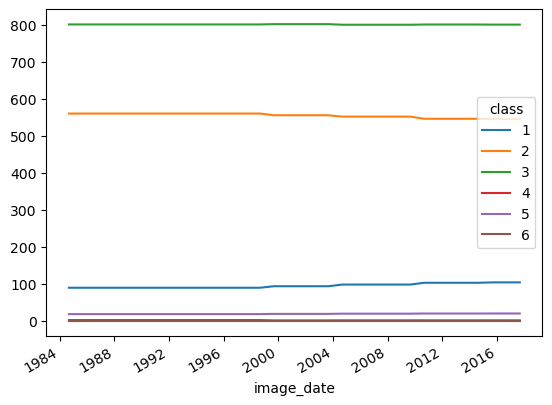

In [13]:
classArea_df1 = pd.read_excel('chooz_weighted.xlsx', header=[0,1], index_col=[0], parse_dates=True)
#acc = pd.Series(accuracy)
#classArea_df1.testing['accuracy2'] = acc
classArea_df1.area_CORINE.plot()

In [14]:
classArea_df1.keys()

MultiIndex([('area_CORINE',                   '1'),
            ('area_CORINE',                   '2'),
            ('area_CORINE',                   '3'),
            ('area_CORINE',                   '4'),
            ('area_CORINE',                   '5'),
            (    'area_RF',                   '1'),
            (    'area_RF',                   '2'),
            (    'area_RF',                   '3'),
            (    'area_RF',                   '4'),
            (    'area_RF',                   '5'),
            (   'training',        'year_trained'),
            ('area_CORINE',                   '6'),
            (  'catchment',                'area'),
            (    'area_RF',                   '6'),
            (  'catchment',               'name '),
            (    'testing',            'accuracy'),
            (        'ind', 'Unnamed: 17_level_1')],
           names=[None, 'class'])

In [15]:
class_name = ['Artificial', 'Agricultural', 'Forest and Semi-Natural', 'Wetlands', 'Waterbodies', 'Masked']

rdx = classArea_df1.reset_index().fillna(0)
for i in range(6):
    print(class_name[i], np.mean(rdx.area_CORINE.iloc[:,i]/rdx.catchment.area))

for i in range(6):
    print(class_name[i], np.mean(rdx.area_RF.iloc[:,i]/rdx.catchment.area))

rdx

Artificial 0.06451778179469594
Agricultural 0.3770746305489745
Forest and Semi-Natural 0.5444791136943509
Wetlands 0.001106081416646922
Waterbodies 0.012887045460919235
Masked 0.0
Artificial 0.06723639737794404
Agricultural 0.3358281378129768
Forest and Semi-Natural 0.5378977801681827
Wetlands 0.011614808730090354
Waterbodies 0.02542709608022902
Masked 0.08923217720852111


image_date area_CORINE                                    \
class                               1           2           3         4   
0     1984-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
1     1985-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
2     1986-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
3     1987-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
4     1988-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
5     1989-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
6     1990-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
7     1991-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
8     1992-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
9     1993-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
10    1994-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
11    1995-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
12    1996-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
13    1997-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
14    1998-08-31 22:00:00   89.595287  560.574046  801.550792  2.011303   
15    1999-08-31 22:00:00   93.671300  555.971606  802.333052  1.191775   
16    2000-08-31 22:00:00   93.671300  555.971606  802.333052  1.191775   
17    2001-08-31 22:00:00   93.671300  555.971606  802.333052  1.191775   
18    2002-08-31 22:00:00   93.671300  555.971606  802.333052  1.191775   
19    2003-08-31 22:00:00   93.671300  555.971606  802.333052  1.191775   
20    2004-08-31 22:00:00   98.206351  552.260103  800.730192  1.373331   
21    2005-08-31 22:00:00   98.206351  552.260103  800.730192  1.373331   
22    2006-08-31 22:00:00   98.206351  552.260103  800.730192  1.373331   
23    2007-08-31 22:00:00   98.206351  552.260103  800.730192  1.373331   
24    2008-08-31 22:00:00   98.206351  552.260103  800.730192  1.373331   
25    2009-08-31 22:00:00   98.206351  552.260103  800.730192  1.373331   
26    2010-08-31 22:00:00  103.031191  546.453761  801.329507  1.373331   
27    2011-08-31 22:00:00  103.031191  546.453761  801.329507  1.373331   
28    2012-08-31 22:00:00  103.031191  546.453761  801.329507  1.373331   
29    2013-08-31 22:00:00  103.031191  546.453761  801.329507  1.373331   
30    2014-08-31 22:00:00  103.031191  546.453761  801.329507  1.373331   
31    2015-08-31 22:00:00  104.061006  545.604586  801.032115  1.373331   
32    2016-08-31 22:00:00  104.061006  545.604586  801.032115  1.373331   
33    2017-08-31 22:00:00  104.061006  545.604586  801.032115  1.373331   

                     area_RF                                                \
class          5           1           2           3          4          5   
0      18.307640   83.964745  677.037061  677.831171   1.929748  26.603761   
1      18.307640   73.123634  490.730324  846.781498  23.945523  32.665004   
2      18.307640   74.809540  496.186339  847.762169  11.174912  34.209218   
3      18.307640   68.286624  458.004928  874.303031  27.772361  39.004204   
4      18.307640   82.811368  471.138171  856.151316  18.980731  37.373257   
5      18.307640   91.363037  429.259205  872.842711  34.732112  39.174083   
6      18.307640   91.778350  516.768841  817.660834   5.980818  35.182306   
7      18.307640   77.968981  479.770912  854.879574  16.840448  37.911234   
8      18.307640   97.691768  578.045998  753.158823   2.126429  35.119384   
9      18.307640   62.817133  278.626446  592.673866  17.459635  37.827160   
10     18.307640  107.746138  350.190700  852.246132  38.328340  44.628511   
11     18.307640   70.303428  310.155415  990.758185  51.156088  44.998033   
12     18.307640   83.668352  313.124876  770.748496  60.913799  29.826032   
13     18.307640   66.195710  318.741538  974.453988  42.560149  43.715394   
14     18.307640  108.172329  414.871033  860.359927  35.825361  4

In [17]:
def compute_rmse(y_true: pd.Series, y_pred: pd.Series) -> float:
    """
    Computes the root mean squared error (RMSE) of two pandas Series.
    """
    # Ensure both Series have the same length
    assert len(y_true) == len(y_pred), "Input Series must have the same length"
    
    # Compute the difference between the true and predicted values
    error = y_true - y_pred
    
    # Compute the mean squared error (MSE)
    mse = np.mean(error**2)
    
    # Compute the RMSE
    rmse = np.sqrt(mse)
    
    return rmse

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Artificial 0.06723639737794404
Agricultural 0.3358281378129768
Forest and Semi-Natural 0.5378977801681827
Wetlands 0.011614808730090354
Waterbodies 0.02542709608022902
Masked 0.08923217720852111
Fixed Mask -0.021995779830576948


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


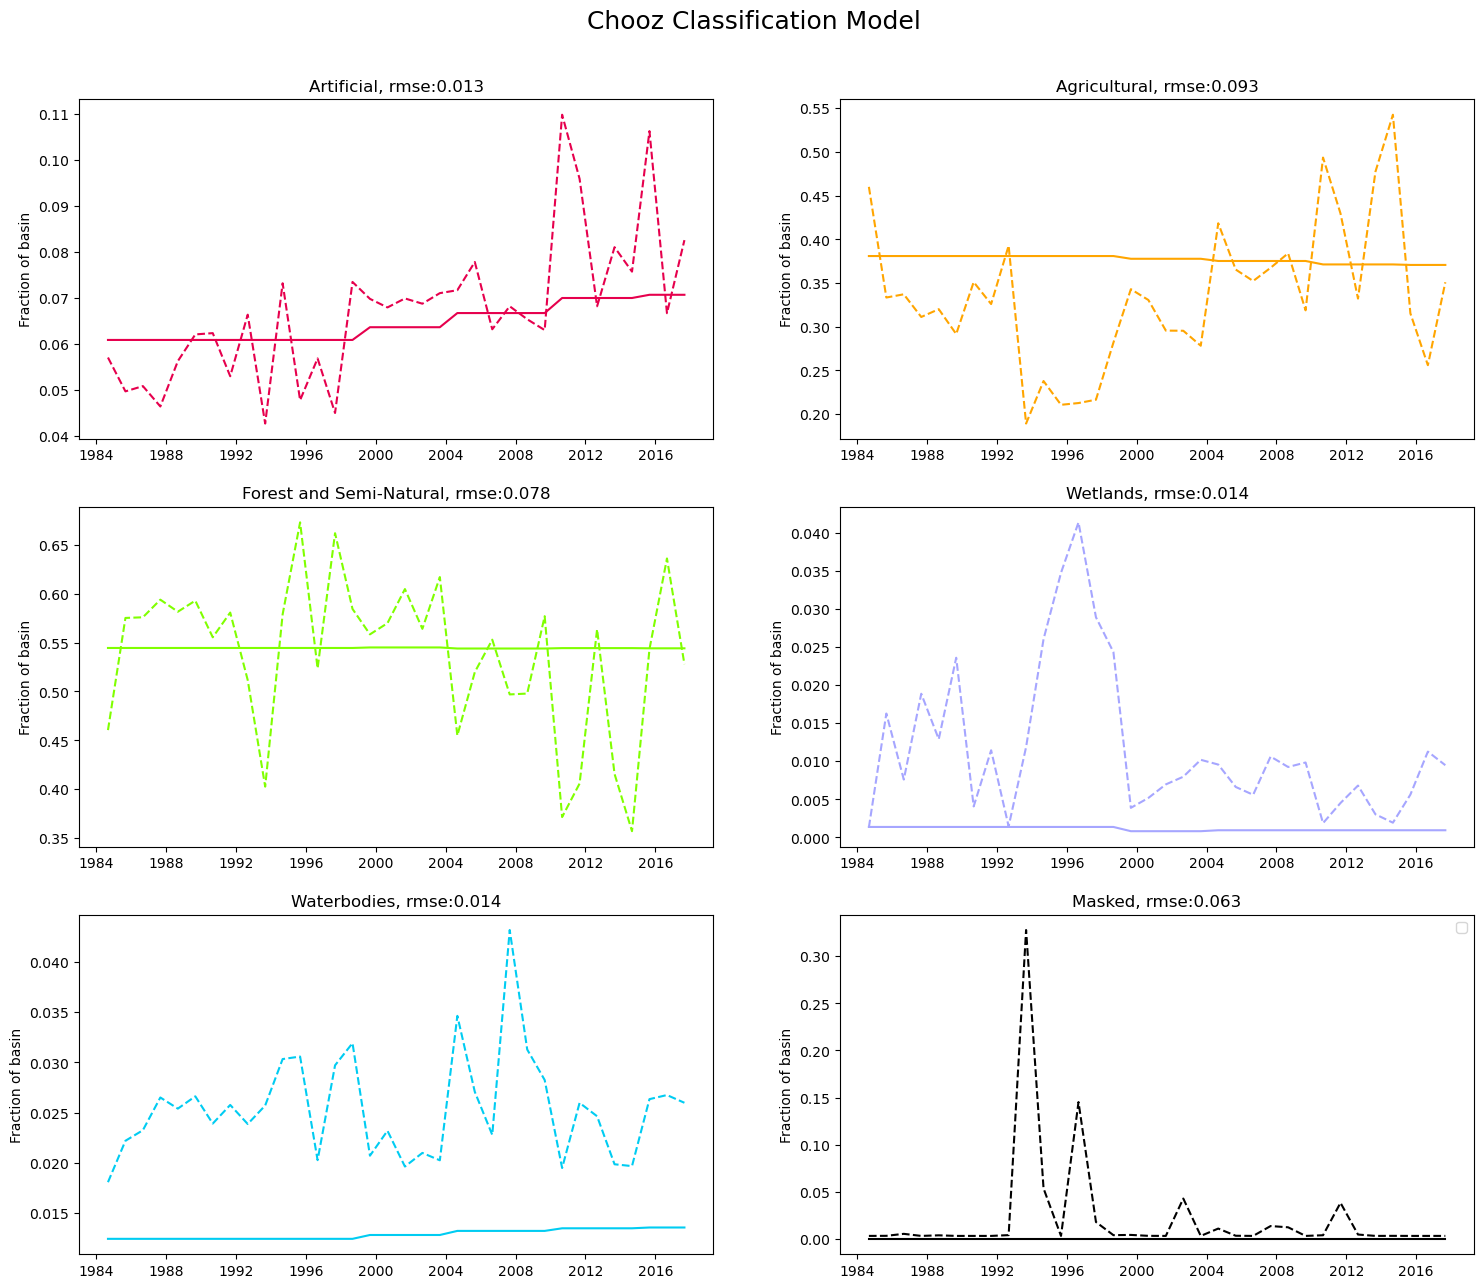

In [19]:

rdx = classArea_df1.reset_index().fillna(0)
# rdx.area_RF.iloc[:, 5] = rdx.area_RF.iloc[:,0:4].sum(axis=1) - rdx.catchment.area
rdx[('area_RF', 'masked')] = rdx.area_RF.iloc[:,0:5].sum(axis=1) - rdx.catchment.area

for i in range(6):
    print(class_name[i], np.mean(rdx.area_RF.iloc[:,i]/rdx.catchment.area))

print('Fixed Mask', np.mean(rdx.area_RF.masked/rdx.catchment.area))


grouped = rdx.groupby('image_date').sum()
grouped

grouped = rdx.groupby('image_date').sum()

colors = ['#E6004D', 'orange', '#80FF00', '#A6A6FF', '#00CCF2', 'black']

fig, axes = plt.subplots(3,2, figsize = (18,15))

tit = plt.suptitle('Chooz Classification Model', y=0.94, size=18)

for i in range(6):
    if i == 0:
        col=0
        row=0
    elif i==1:
        col=1
        row=0
    elif i==2:
        col=0
        row=1
    elif i==3:
        col=1
        row=1
    elif i==4:
        col=0
        row=2
    
    if i<5:
        y_pred = grouped.area_RF.iloc[:,i]/grouped.catchment.area
    
        y_true = grouped.area_CORINE.iloc[:,i]/grouped.catchment.area

        rmse = compute_rmse(y_true, y_pred)
        ax = axes[row, col]
        ax.set_title(f'{class_name[i]}, rmse:{rmse:.3f}')
        ax.plot(y_pred,linestyle='dashed', c=colors[i], label=f'{class_name[i]} modelled')
        ax.plot(y_true, c=colors[i], label=f'{class_name[i]} corine')
        ax.set_ylabel('Fraction of basin')
        plt.legend()
    
    if i==5:
        col=1
        row=2
        ax = axes[row, col]
        y_pred = grouped.area_RF.masked.abs()/grouped.catchment.area
    
        y_true = grouped.area_CORINE.iloc[:,i]/grouped.catchment.area

        rmse = compute_rmse(y_true, y_pred)
        ax.set_title(f'{class_name[i]}, rmse:{rmse:.3f}')
        ax.plot(y_pred, linestyle='dashed', c=colors[i], label= f'')
        ax.plot(y_true/grouped.catchment.area, c=colors[i])
        ax.set_ylabel('Fraction of basin')



In [73]:
class_search = pd.read_excel('../Outputs/meuse/RF_classification/preTuning/classifier_search.xlsx', header=[0,1], index_col=0, parse_dates=True)
class_search.keys()

MultiIndex([('area_CORINE',                   '1'),
            ('area_CORINE',                   '2'),
            ('area_CORINE',                   '3'),
            ('area_CORINE',                   '4'),
            ('area_CORINE',                   '5'),
            (    'area_RF',                   '1'),
            (    'area_RF',                   '2'),
            (    'area_RF',                   '3'),
            (    'area_RF',                   '4'),
            (    'area_RF',                   '5'),
            (   'training',        'year_trained'),
            ('area_CORINE',                   '6'),
            (  'catchment',                'area'),
            (    'area_RF',                   '6'),
            (  'catchment',               'name '),
            (    'testing',            'accuracy'),
            (        'ind', 'Unnamed: 17_level_1')],
           names=[None, 'class'])

In [74]:
year_classified = [1990, 2000, 2006, 2012, 2018]

for year in year_classified:
    class_search.groupby(('training', 'year_trained')).get_group(year).sort_values(by=('testing', 'accuracy'), ascending=False).to_excel(f'../Outputs/meuse/RF_classification/classifier_ranking_{year}.xlsx')

In [75]:
catchment = ['Chooz', 'Chooz', 'Chooz', 'treignes', 'Chooz']
accuracy = [0.789369, 0.783634, 0.803112, 0.796622, 0.796321]
acc_post = [0.945, 0.957, 0.955, 0.960, 0.956]
group = pd.read_excel(f'../Outputs/meuse/RF_classification/preTuning/classifier_ranking_{year_classified[4]}.xlsx', header=[0,1], index_col=0, parse_dates=True).dropna()
group

area_CORINE                                               \
class                         1           2           3         4          5   
image_date                                                                     
2018-08-31 22:00:00  108.696124  600.561064  859.017972  1.373331  19.890701   
2018-08-31 22:00:00   35.427795  218.596639  292.070370  0.907128   1.304537   
2018-08-31 22:00:00    6.957725  263.506508  130.410072  2.640857   2.294175   

                        area_RF                                                \
class                         1           2           3          4          5   
image_date                                                                      
2018-08-31 22:00:00  166.729849  494.983704  788.659230  77.415980  57.183356   
2018-08-31 22:00:00   73.821864  172.814694  255.115498  38.918854   5.460617   
2018-08-31 22:00:00   59.673091  185.001977  125.209307  26.706760   7.395682   

                        training area_CORINE    catchment     area_RF  \
class               year_trained           6         area           6   
image_date                                                              
2018-08-31 22:00:00         2018           0  1589.539192  171.296922   
2018-08-31 22:00:00         2018           0   548.306470   75.996808   
2018-08-31 22:00:00         2018           0   405.809337   61.495611   

                            catchment   testing                 ind  
class                           name   accuracy Unnamed: 17_level_1  
image_date                                                           
2018-08-31 22:00:00             Chooz  0.796321                 0_4  
2018-08-31 22:00:00          Treignes  0.784553                 6_4  
2018-08-31 22:00:00  La Bar Cheveuges  0.774127                 8_4

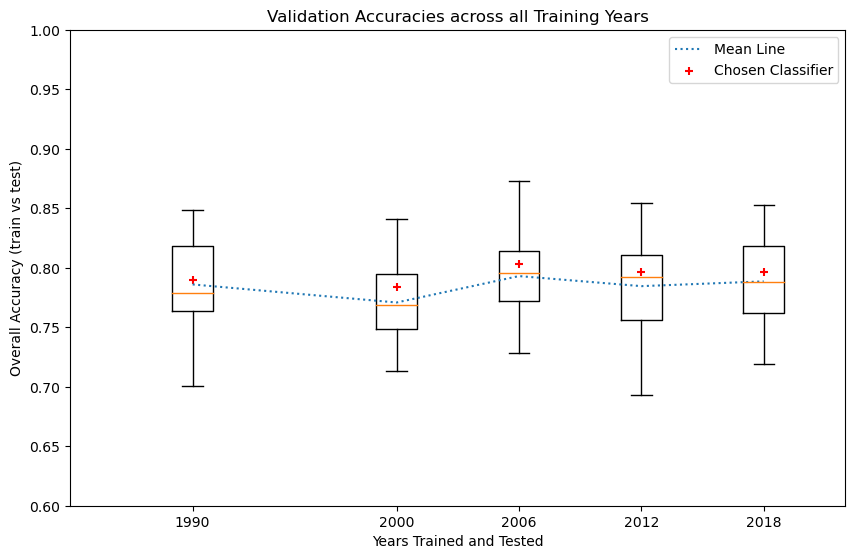

In [83]:
fig,ax = plt.subplots(figsize=(10,6.18))
#ax.set_xticks(list(np.arange(1984, 2022)), list(np.arange(1984, 2022)))
groups = class_search.groupby((   'training', 'year_trained'))
ls = []
means = []
for year in year_classified:
    y = groups.get_group(year)[('testing',     'accuracy')].values
    ls.append(y)
    means.append(np.mean(y))
ax.boxplot(ls, positions=year_classified, widths=2, meanline=True)
ax.plot(year_classified, means, ls=':', label='Mean Line')
ax.scatter(year_classified, accuracy, marker='+', c='r', label='Chosen Classifier')

ax.set_xlabel('Years Trained and Tested')
ax.set_ylabel('Overall Accuracy (train vs test)')
ax.set_ylim(0.6, 1)
ax.set_xlim(1984, 2022)
ax.legend()
ax.set_title('Validation Accuracies across all Training Years');

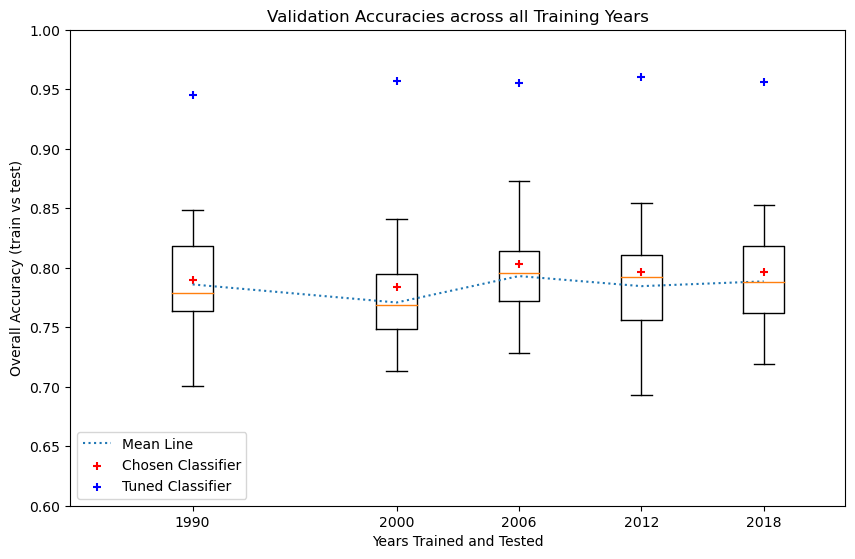

In [86]:
fig,ax = plt.subplots(figsize=(10,6.18))
#ax.set_xticks(list(np.arange(1984, 2022)), list(np.arange(1984, 2022)))
ls = []
means = []
for year in year_classified:
    y = groups.get_group(year)[('testing',     'accuracy')].values
    ls.append(y)
    means.append(np.mean(y))
ax.boxplot(ls, positions=year_classified, widths=2, meanline=True)
ax.plot(year_classified, means, ls=':', label='Mean Line')
ax.scatter(year_classified, accuracy, marker='+', c='r', label='Chosen Classifier')
ax.scatter(year_classified, acc_post, marker='+', c='b', label='Tuned Classifier')
ax.set_xlabel('Years Trained and Tested')
ax.set_ylabel('Overall Accuracy (train vs test)')
ax.set_ylim(0.6, 1)
ax.set_xlim(1984, 2022)
ax.legend()
ax.set_title('Validation Accuracies across all Training Years');

In [ ]:
fig,ax = plt.subplots()
#ax.set_xticks(list(np.arange(1984, 2022)), list(np.arange(1984, 2022)))
groups = classArea_df.groupby((   'training', 'year_trained'))
ls = []
means = []
for year in year_classified:
    y = groups.get_group(year)[('area_RF',     '6')].values
    ls.append(y)
    means.append(np.mean(y))
ax.boxplot(ls, positions=year_classified, widths=2, meanline=True)
ax.plot(year_classified, means, ls=':', label='mean line')
# ax.set_ylim(0.6, 0.9)
# ax.set_xlim(1984, 2022)
ax.legend()
ax.set_title('Masked Pixels across all Training Years');

In [224]:
groups.get_group(1990)[('area_RF',     '6')].values

array([  170.04494064, -1121.04137693, -1990.        ,   288.9496701 ,
       -1188.77559444, -1507.10129803,    81.80562092, -1990.        ,
          57.5897379 , -1990.        , -1990.        , -1639.97102917,
       -1747.56122536, -1990.        , -1990.        , -1855.4575343 ,
       -1990.        , -1990.        , -1990.        , -1852.2925636 ,
       -1990.        , -1990.        ])

In [304]:
headers = ('catchment', 'year', 'classes')
ranking_classifiers = [ ('la Meuse Stenay', 2012, 4)]
#print(type(headers[0]))
df = pd.DataFrame(ranking_classifiers, columns=headers)#, dtype=[(headers[0], 'U')])#, (headers[1], int()), (headers[2], int())])
df.dtypes

catchment    object
year          int64
classes       int64
dtype: object

In [217]:
Map=geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(trainingClassImage, {'band':['landcover'], 'min':1, 'max':5, 'palette':['red', 'yellow', 'green', 'purple', 'blue']}, 'Train on')
Map.addLayer(imageToClassify, {'band':['B3', 'B2','B1'], 'min':0, 'max':1200, 'gamma':0.9}, 'RGB')
Map.addLayer(classified, {'band':['landcover'], 'min':1, 'max':5, 'palette':['red', 'yellow', 'green', 'purple', 'blue']}, 'Classified')

Map

Map(center=[49.77390824509992, 4.868050388133598], controls=(WidgetControl(options=['position', 'transparent_b…

In [120]:
def maskedPixelCount(image, band, geom, scale):
    im = image.select(band)
    Pix = im.reduceRegion(**{
                                'reducer':ee.Reducer.count(),
                                'geometry':geom,
                                'scale':im.projection().nominalScale(),
                                'crs':im.projection(),
                                'maxPixels':1e9,
                                }).get(band)
    unmaskPix = im.unmask(1).reduceRegion(**{
                                'reducer':ee.Reducer.count(),
                                'geometry':geom,
                                'scale':im.projection().nominalScale(),
                                'crs':im.projection(),
                                'maxPixels':1e9,
                                }).get(band)
    maskedPix = ee.Number(unmaskPix).subtract(ee.Number(Pix))
    return [Pix.getInfo(), unmaskPix.getInfo(), maskedPix.getInfo()]

def pixelToArea(pixels, scale):
    '''
    x [pixels] * y [sqm / pixel]
    --------------------------   = area [sq km]
        z [sqm / sqkm]
    '''
    return (pixels*scale)/1e6

In [284]:
pix1, unmaskPix1, maskedPixels1 = maskedPixelCount(imageToClassify, 'B1', aoi, 30)
pix2, unmaskPix2, maskedPixels2 = maskedPixelCount(classified, 'classification', aoi, 30)
pix3, unmaskPix3, maskedPixels3 = maskedPixelCount(trainingClassImage, 'landcover', aoi, 30)

In [216]:
areaBand = ee.Image.pixelArea().divide(1e6)
image = classified.addBands(areaBand)

areas = image.select('area').reduceRegion(**{
        'reducer':ee.Reducer.sum(),
        'geometry':aoi,
        'scale':30,
        # 'crs':'EPSG:3035',
        'maxPixels':1e13,
        'bestEffort':True,
})

areas
#classAreasLists = classAreas.map(extractArea) #6191.08

In [206]:
(classAreas.getInfo() / 253 )

1579.1635123614628

In [268]:
ca = classArea(trainingClassImage, 100).getInfo()

# print('masked pixels in LS composite, area in sqKm:', pixelToArea(maskedPixels1, 30))

print('masked pixels in classified, area in sqKm:', pixelToArea(maskedPixels2, 30))

print('masked pixels in training, area in sqKm:', pixelToArea(maskedPixels3, 30))

In [283]:
df.area_CORINE.sum(axis=1)

date
2011-08-31 22:00:00    1589.539192
dtype: float64

In [263]:
df.year_trained

date
2011-08-31 22:00:00    2011
Name: year_trained, dtype: int64

In [ ]:
chart_min_region = chart.Image.series(**{
'imageCollection': clear_collection,
'reducer': ee.Reducer.min(),
'region': aoi,
'scale': scale,
'band': 'B1_min',
}).dataframe
chart_min_region

In [ ]:
Map.addLayer(imcol.first(), RGB_VIS, '')
Map.centerObject(aoi, 10)
Map

In [ ]:
def plot_band_timeseries(annual_df ,  bands=[], percentile=False, decadal= True, separate=False):
    fignum = 0
    for i in bands:
        if separate == True:
            fignum+=1
        plt.figure(fignum)
        df = annual_df.loc[:,i]
        #display(df)
        
        plt.title(f'{bands} Timeseries')
        
        c = 'blue'
        fill  = 'grey'
        
        
        
        if i == 'B1':
            c = 'blue'
            fill  = c
        
        if i == 'B2':
            c = 'green'
            fill  = c
        
        if i == 'B3':
            c = 'red'
            fill=c
            
        if i == 'gndvi':
            c = 'green'
            fill  = c
        
        df.plot(figsize=(20, 10), color=c)
        
        if decadal == True:
            
            decadal_mean = df.rolling(10).mean()
            decadal_mean.plot(c='red', linestyle='dashed', label=f'Decadal Mean {i}')
            plt.axvline(annual_df.index[0], linestyle='dotted')
            plt.scatter(annual_df.index[9], decadal_mean[9], label=f'{i} mean 1984-1993')
            plt.axvline(annual_df.index[9], linestyle='dotted')
            plt.scatter(annual_df.index[19], decadal_mean[19], label=f'{i} mean 1994-2003')
            plt.axvline(annual_df.index[19], linestyle='dotted')
            plt.scatter(annual_df.index[29], decadal_mean[29], label=f'{i} mean 2004-2013')
            plt.axvline(annual_df.index[29], linestyle='dotted')
        
        if percentile == True:
            df_5 = annual_df.loc[:,f'{i}p5']
            df_95 = annual_df.loc[:,f'{i}p95']
            
            df_5.plot(color='black', linestyle='dashed', alpha=0.7, label=f'{i} p0.05')
            df_95.plot(color='black', linestyle='dashed', alpha=0.7, label=f'{i} p0.95')
            plt.fill_between(annual_df.index, df_5, df_95, color=fill, alpha=0.2)
            plt.title(f'{bands} Timeseries With Decadal Mean and Percentile Bands')
        

        # Add axis labels and a legend
        plt.xlabel('Year')
        
        plt.ylabel(f'mean surface reflectance / $km^2$')
        
        plt.suptitle('La Meuse Stenay 1984 - 2022')
        
        

        #plt.ylim(df.min() - (df.min()*0.7), df.max()*1.2,)
        plt.legend()

plot_band_timeseries(annual, ['ndvi', 'gndvi'], decadal=False)


In [ ]:
fignum+=1
plt.figure(fignum)
#annual.ndvi.plot(figsize=(20, 10), c='blue')
decadal_mean = annual.ndvi.rolling(10).mean()
decadal_mean.plot(figsize=(20, 10), c='red', label='Decadal Mean')
#annual.ndvip5.plot(color='black', linestyle='dashed', alpha=0.7, label='NDVI p0.05')
#annual.ndvip95.plot(color='black', linestyle='dashed', alpha=0.7, label='NDVI p0.95')
plt.fill_between(annual.index, annual.ndvip5, annual.ndvip95, color='grey', alpha=0.2)
plt.axvline(annual.index[0], linestyle='dotted')
plt.scatter(annual.index[9], decadal_mean[9], label='NDVI mean 1984-1993')
plt.axvline(annual.index[9], linestyle='dotted')
plt.scatter(annual.index[19], decadal_mean[19], label='NDVI mean 1994-2003')
plt.axvline(annual.index[19], linestyle='dotted')
plt.scatter(annual.index[29], decadal_mean[29], label='NDVI mean 2004-2013')
plt.axvline(annual.index[29], linestyle='dotted')

# Add axis labels and a legend
plt.xlabel('Year')
plt.ylabel('NDVI [$/km^2$]')

plt.suptitle('La Meuse Stenay 1984 - 2022')
plt.title('NDVI Timeseries With Decadal Mean and Percentile Bands')

plt.ylim(0.55,0.75)
plt.xlim(annual.index[8], annual.index[32])
plt.legend()


In [ ]:
annual

## Trend analysis per band

- can we look at median band collection and percentile bounds, reduced to a per kilometer scale

In [ ]:
stats_LS = geemap.image_stats(LS, aoi, scale=scale)
LS_col_stats = stats_LS.getInfo()
print(LS_col_stats)

***
<a id="Land_Cover"></a>
## Land Cover 

[Linking Reference to Land Cover](#Land_cover)

In [ ]:
Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.addLayer(aoi, {}, 'ROI')
Map.centerObject(aoi, 12)
Map